# BERT model with Prompt for QQP

- **Dataset**: Quora Question Pairs
- **Model**: Bert-uncased
- **Tuning approach**: Prompt

## Step 1: Import libraries + load dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score
from datasets import load_dataset

In [2]:
dataset = load_dataset("quora", trust_remote_code=True, split='train[:100000]')
print(f"dataset info:", dataset)
dataset[0]['questions']

README.md:   0%|          | 0.00/5.69k [00:00<?, ?B/s]

quora.py:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/404290 [00:00<?, ? examples/s]

dataset info: Dataset({
    features: ['questions', 'is_duplicate'],
    num_rows: 100000
})


{'id': [1, 2],
 'text': ['What is the step by step guide to invest in share market in india?',
  'What is the step by step guide to invest in share market?']}

## Step 2: Load model + preprocessing

- Visualize the balance of data

- Load BEFT model and BEFT tokenizer

- Load Promt tuning PEFT tuning technique

- Numericalize data: convert questions into numerical format

- Split data into train, validation & test sets

### Visualize the labels

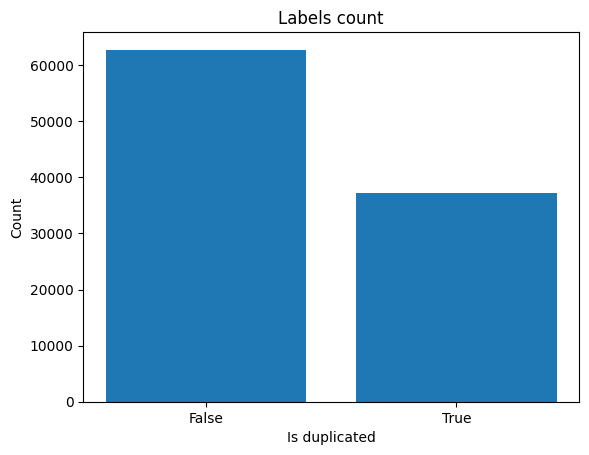

In [3]:
from typing import Counter
counts = Counter(dataset['is_duplicate'])

keys = [str(key) for key in counts.keys()]
values = list(counts.values())
plt.bar(keys, values)
plt.title("Labels count")
plt.xlabel("Is duplicated")
plt.ylabel("Count")
plt.show()

### Convert `is_duplicate` from bool to int

In [4]:
dataset = dataset.map(lambda ex: {'label': 1 if ex['is_duplicate'] else 0})
dataset[0]['label']

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

0

### Load BEFT model and BEFT tokenizer

In [5]:
from transformers import BertTokenizerFast, BertForSequenceClassification
model_name = 'bert-base-uncased'

tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)
bert_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2, output_attentions=False, output_hidden_states=False)
bert_model

2025-05-31 10:44:59.628752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748688299.824896      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748688299.881144      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Numericalize dataset

- Pair of questions is firstly concatenated

- `max_length` is determine, and then every sentence are padded to `max_length`

#### Get max length of concatenated sentence

In [6]:
dataset = dataset.map(lambda example: {
                            "token_lens": len(tokenizer.encode(example["questions"]['text'][0],
                                                            example["questions"]['text'][1])),
                        })

max_length = max(dataset["token_lens"])
max_length

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

330

In [7]:
dataset[0].keys()

dict_keys(['questions', 'is_duplicate', 'label', 'token_lens'])

#### Tokenize data

In [8]:
def tokenize(example, tokenizer, max_length):
    encode_res = tokenizer.encode_plus(example["questions"]['text'][0], example["questions"]['text'][1],
                                       padding="max_length", truncation=True, max_length=max_length, return_tensors='pt')
    return {'input_ids': encode_res['input_ids'].squeeze(0), 'attention_mask': encode_res['attention_mask'].squeeze(0)}

dataset = dataset.map(tokenize, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length})
dataset.set_format(type="torch", columns=['input_ids', 'attention_mask', 'label'])

dataset[0].keys()

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

dict_keys(['label', 'input_ids', 'attention_mask'])

In [9]:
dataset_dict = dataset.train_test_split(test_size=0.4, seed=2025, shuffle=True)
train_data = dataset_dict['train']
dataset_dict = dataset_dict['test'].train_test_split(test_size=0.5, seed=2025, shuffle=True)
valid_data = dataset_dict['train']
test_data = dataset_dict['test']
len(train_data), len(test_data), len(valid_data)

(60000, 20000, 20000)

## Step 3: Model training

### Define model hyperparameter

In [10]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 6

### Split data into batches

In [11]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)
print(f"Number of train batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")
print(f"Number of valid batches: {len(valid_loader)}")

Number of train batches: 1875
Number of test batches: 625
Number of valid batches: 625


### Train

In [12]:
import time
import datetime
from peft import PeftModel, get_peft_model_state_dict

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def accuracy_score_fn(outputs, labels):
    predictions = np.argmax(outputs, axis=1)
    return accuracy_score(labels, predictions)

def save_model(model, path):
    if isinstance(model, PeftModel):
        # It's a PEFT model like LoRA
        state_dict = get_peft_model_state_dict(model)
    else:
        # It's a regular HuggingFace model like in BitFit
        state_dict = model.state_dict()
    torch.save(state_dict, path)

def evaluate(model, val_loader, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for idx, batch in enumerate(val_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)  # Assuming labels are numerical and can be moved to the device

            # Prepare inputs for the model
            model_inputs = {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels": labels,
            }

            outputs = model(**model_inputs)
            loss = outputs.loss
            total_loss += loss.item()

            # Accuracy score
            all_preds.extend(outputs.logits.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

            ### TODO: DELETE IT
            # break

    avg_val_loss = total_loss / len(val_loader)
    value = accuracy_score_fn(np.array(all_preds), np.array(all_labels))
    return avg_val_loss, value

def train_and_save(model, train_loader, val_loader, output_dir, device, lr, epochs, save_fn = save_model):
    # only update the parameters that require gradients in the case of BitFit or Lora
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    best_loss = float('inf')

    for epoch in range(1, epochs + 1):
        start = time.time()
        model.train()
        total_loss = 0.0
        patience = 0        # Early stopping

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch} Training", leave=False)

        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)  # Assuming labels are numerical

            # Prepare inputs for the model
            model_inputs = {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels": labels,
            }

            outputs = model(**model_inputs)

            loss = outputs.loss # Loss function is provided by the Sentence Classification head
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

            progress_bar.set_postfix(loss=loss.item())

            ### TODO: DELETE IT
            # break
        avg_loss = total_loss / len(train_loader)

        val_loss, accuracy_score = evaluate(model, val_loader, device)
        train_duration = time.time() - start
        print(f"Epoch {epoch} - Average loss: {avg_loss:.4f} - Trainning duration: {str(datetime.timedelta(seconds=int(train_duration)))}")
        print(f"Average Validation Loss: {val_loss:.4f} - Validation accuracy: {accuracy_score:.4f}")

        if val_loss < best_loss:
            patience = 0
            best_loss = val_loss
            save_fn(model, output_dir)
            print(f"Saved model in {output_dir}")
        else:
            patience += 1
            if patience == 2:
                print("Early stopping triggered. No improvement in validation loss.")
                break


### Load Promt tuning for PEFT

In [13]:
from peft import PromptTuningConfig, get_peft_model, get_peft_model_state_dict

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"usage device: {device}")

# prompt_config = PromptTuningConfig(
#     task_type="SEQ_CLS",
#     num_virtual_tokens=10,
#     tokenizer_name_or_path="bert-base-uncased"
# )

prompt_config = PromptTuningConfig(
    task_type="SEQ_CLS",
    num_virtual_tokens=20,
    prompt_tuning_init="RANDOM",
    tokenizer_name_or_path="bert-base-uncased",
    num_layers=5,
    token_dim=768,
    num_attention_heads=3,
)

prompt_bert_model = get_peft_model(bert_model, prompt_config)
prompt_bert_model.to(device)

usage device: cuda


PeftModelForSequenceClassification(
  (base_model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_fe

In [14]:
# Count the number of trainable parameters in Promt tuning
num_lora_params = sum(p.numel() for p in prompt_bert_model.parameters() if p.requires_grad)
print(f"Number of trainable Promt tuning parameters: {num_lora_params}")

Number of trainable Promt tuning parameters: 16898


In [15]:
model_version = 1
train_and_save(prompt_bert_model, train_loader, valid_loader, f"bert_prompt_model_v{model_version}.pt",\
               device=device,lr=LEARNING_RATE,epochs=EPOCHS,save_fn=save_model)

Epoch 1 - Average loss: 0.6285 - Trainning duration: 0:49:31
Average Validation Loss: 0.5642 - Validation accuracy: 0.6979
Saved model in bert_prompt_model_v1.pt


Epoch 2 - Average loss: 0.5866 - Trainning duration: 0:49:33
Average Validation Loss: 0.5810 - Validation accuracy: 0.6851


Epoch 3 - Average loss: 0.5652 - Trainning duration: 0:49:32
Average Validation Loss: 0.5654 - Validation accuracy: 0.6992


Epoch 4 - Average loss: 0.5503 - Trainning duration: 0:49:32
Average Validation Loss: 0.5449 - Validation accuracy: 0.7127
Saved model in bert_prompt_model_v1.pt


Epoch 5 - Average loss: 0.5425 - Trainning duration: 0:49:32
Average Validation Loss: 0.5000 - Validation accuracy: 0.7405
Saved model in bert_prompt_model_v1.pt


Epoch 6 - Average loss: 0.5312 - Trainning duration: 0:49:32
Average Validation Loss: 0.5367 - Validation accuracy: 0.7179


## Step 4: Model evaluation

In [16]:
from peft import set_peft_model_state_dict

prompt_tuning_path = f"bert_prompt_model_v{model_version}.pt"

state_dict = torch.load(prompt_tuning_path, weights_only=True, map_location=device)
set_peft_model_state_dict(prompt_bert_model, state_dict)
prompt_bert_model.to(device)

test_loss, test_acc = evaluate(prompt_bert_model, test_loader, device)
print(f"Average Test Loss: {test_loss:.4f} - Test accuracy: {test_acc:.4f}")

Average Test Loss: 0.4965 - Test accuracy: 0.7470
